In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
import requests
import zipfile
import os
import re
from io import BytesIO
from urllib.parse import urlparse

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load data
print("Loading data...")
df = pd.read_parquet('../data/hackernews_full_data.parquet')
print(f"Loaded {len(df):,} stories")

# Use a substantial sample for training
df_sample = df.sample(n=4900000, random_state=42).copy()
print(f"Using {len(df_sample):,} samples")


Using device: cpu
Loading data...
Loaded 4,902,536 stories
Using 4,900,000 samples


In [2]:
# Load GloVe embeddings for title embeddings
print("🔄 Loading pre-trained GloVe embeddings...")

glove_file = "../data/glove.6B.200d.txt"

if not os.path.exists(glove_file):
    print("Downloading GloVe 200d embeddings (this may take a moment)...")
    url = "https://nlp.stanford.edu/data/glove.6B.zip"
    
    response = requests.get(url, stream=True)
    with zipfile.ZipFile(BytesIO(response.content)) as zip_file:
        with zip_file.open("glove.6B.200d.txt") as source:
            with open(glove_file, "wb") as target:
                target.write(source.read())
    print("✅ Download complete!")

# Load GloVe embeddings
print("Loading GloVe word vectors...")
word_to_index = {}
embeddings_list = []

with open(glove_file, 'r', encoding='utf-8') as f:
    for idx, line in enumerate(f):
        if idx % 50000 == 0:
            print(f"  Loaded {idx:,} words...")
        
        parts = line.strip().split()
        word = parts[0]
        vector = np.array([float(x) for x in parts[1:]])
        
        word_to_index[word] = len(embeddings_list)
        embeddings_list.append(vector)

embeddings = np.array(embeddings_list)

print(f"✅ GloVe embeddings loaded:")
print(f"  Vocabulary: {len(word_to_index):,} words")
print(f"  Embedding dim: {embeddings.shape[1]}")


🔄 Loading pre-trained GloVe embeddings...
Loading GloVe word vectors...
  Loaded 0 words...
  Loaded 50,000 words...
  Loaded 100,000 words...
  Loaded 150,000 words...
  Loaded 200,000 words...
  Loaded 250,000 words...
  Loaded 300,000 words...
  Loaded 350,000 words...
✅ GloVe embeddings loaded:
  Vocabulary: 400,000 words
  Embedding dim: 200


In [3]:
# Feature engineering functions
def clean_text(text):
    """Clean text for embedding lookup"""
    text = text.lower()
    text = re.sub(r'-', ' ', text)  # Split hyphenated words
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.split()

def title_to_embedding(title, method='average'):
    """Convert title to embedding using GloVe"""
    words = clean_text(title)
    word_embeddings = []
    
    for word in words:
        if word in word_to_index:
            idx = word_to_index[word]
            word_embeddings.append(embeddings[idx])
    
    if word_embeddings:
        if method == 'average':
            return np.mean(word_embeddings, axis=0)
        elif method == 'sum':
            return np.sum(word_embeddings, axis=0)
        elif method == 'max':
            return np.max(word_embeddings, axis=0)
        else:
            return np.mean(word_embeddings, axis=0)
    else:
        return np.zeros(embeddings.shape[1])

def extract_domains(url):
    """Enhanced domain extraction with better cleansing"""
    if url is None or pd.isna(url) or url == '':
        return 'self_post'
    
    url = str(url).strip()
    if not url:
        return 'self_post'
    
    try:
        # Add protocol if missing
        if not url.startswith(('http://', 'https://')):
            url = 'https://' + url
        
        domain = urlparse(url).netloc.lower()
        
        # Remove common prefixes and suffixes
        prefixes = ['www.', 'm.', 'mobile.', 'old.']
        for prefix in prefixes:
            if domain.startswith(prefix):
                domain = domain[len(prefix):]
                break
        
        # Remove port numbers and trailing dots
        domain = domain.split(':')[0].rstrip('.')
        
        return domain if domain else 'parse_error'
        
    except:
        return 'parse_error'

def normalize_common_domains(domain):
    """Group related domains together"""
    domain_groups = {
        # Google ecosystem
        'youtube.com': 'google.com', 'youtu.be': 'google.com', 
        'blogspot.com': 'google.com', 'googleblog.blogspot.com': 'google.com',
        
        # Social media
        't.co': 'twitter.com', 'fb.me': 'facebook.com',
        
        # URL shorteners
        'bit.ly': 'url_shortener', 'tinyurl.com': 'url_shortener', 
        'goo.gl': 'url_shortener', 'ow.ly': 'url_shortener',
        
        # News variations
        'nyti.ms': 'nytimes.com',
        
        # GitHub
        'github.io': 'github.com',
        
        # Wikipedia
        'en.wikipedia.org': 'wikipedia.org'
    }
    
    return domain_groups.get(domain, domain)

print("✅ Feature engineering functions ready!")

✅ Feature engineering functions ready!


In [4]:
# Prepare the dataset with all features
print("Preparing comprehensive dataset...")

# Filter data: remove extreme outliers and missing values
df_filtered = df_sample[
    (df_sample['score'] >= 10) &
    (df_sample['score'] <= 1000) &
    (df_sample['title'].notna()) &
    (df_sample['by'].notna()) &
    (df_sample['time'].notna())
].copy()

print(f"Filtered to {len(df_filtered):,} samples")

# 1. Target: Log transform to fix skewing
df_filtered['score_log'] = np.log1p(df_filtered['score'])

# 2. Title features: embeddings + word count
print("Processing title features...")
title_embeddings = []
word_counts = []

for i, title in enumerate(df_filtered['title']):
    if i % 10000 == 0:
        print(f"  Processing {i:,}/{len(df_filtered):,}...")
    
    emb = title_to_embedding(title)
    word_count = len(title.strip().split())
    
    title_embeddings.append(emb)
    word_counts.append(word_count)

df_filtered['word_count'] = word_counts

# 3. Time features: cyclical encoding
print("Processing time features...")
df_filtered['timestamp'] = pd.to_datetime(df_filtered['time'])
df_filtered['hour_of_day'] = df_filtered['timestamp'].dt.hour

# Cyclical features for time of day
df_filtered['time_of_day_sin'] = np.sin(2 * np.pi * df_filtered['hour_of_day'] / 24)
df_filtered['time_of_day_cos'] = np.cos(2 * np.pi * df_filtered['hour_of_day'] / 24)

# 4. Domain processing with enhanced cleaning
print("Processing domain features...")
df_filtered['domain'] = df_filtered['url'].apply(extract_domains)
df_filtered['domain_normalized'] = df_filtered['domain'].apply(normalize_common_domains)
print("Sample domains:")
print(df_filtered['domain'].value_counts().head(10))

# 5. User processing for embeddings  
print("Processing user features...")
# Users are already in 'by' column

print("✅ Feature processing complete!")
print(f"Score range (original): {df_filtered['score'].min()} to {df_filtered['score'].max()}")
print(f"Score range (log): {df_filtered['score_log'].min():.3f} to {df_filtered['score_log'].max():.3f}")
print(f"Unique domains: {df_filtered['domain'].nunique():,}")
print(f"Unique normalized domains: {df_filtered['domain_normalized'].nunique():,}")
print(f"Unique users: {df_filtered['by'].nunique():,}")

Preparing comprehensive dataset...
Filtered to 671,921 samples
Processing title features...
  Processing 0/671,921...
  Processing 10,000/671,921...
  Processing 20,000/671,921...
  Processing 30,000/671,921...
  Processing 40,000/671,921...
  Processing 50,000/671,921...
  Processing 60,000/671,921...
  Processing 70,000/671,921...
  Processing 80,000/671,921...
  Processing 90,000/671,921...
  Processing 100,000/671,921...
  Processing 110,000/671,921...
  Processing 120,000/671,921...
  Processing 130,000/671,921...
  Processing 140,000/671,921...
  Processing 150,000/671,921...
  Processing 160,000/671,921...
  Processing 170,000/671,921...
  Processing 180,000/671,921...
  Processing 190,000/671,921...
  Processing 200,000/671,921...
  Processing 210,000/671,921...
  Processing 220,000/671,921...
  Processing 230,000/671,921...
  Processing 240,000/671,921...
  Processing 250,000/671,921...
  Processing 260,000/671,921...
  Processing 270,000/671,921...
  Processing 280,000/671,92

🔄 Analyzing current score distribution...


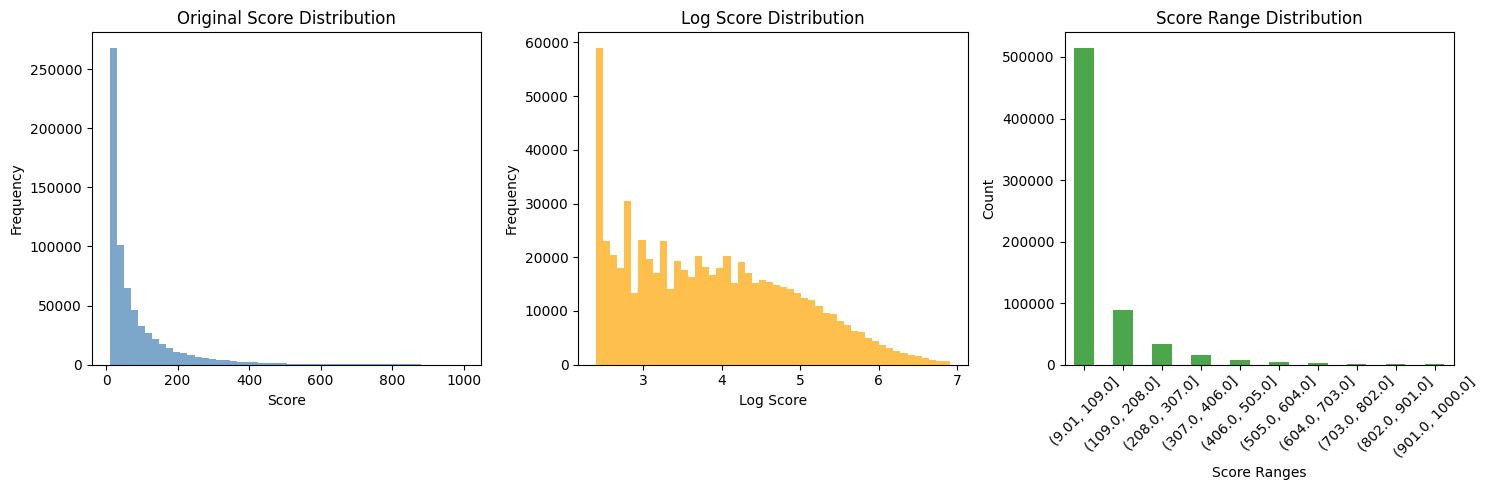

Score statistics:
  Min: 10
  Max: 1000
  Mean: 85.1
  Median: 42.0
  Std: 114.2

Score range counts:
  (9.01, 109.0]: 514,280 samples
  (109.0, 208.0]: 89,601 samples
  (208.0, 307.0]: 34,322 samples
  (307.0, 406.0]: 15,588 samples
  (406.0, 505.0]: 7,826 samples
  (505.0, 604.0]: 4,254 samples
  (604.0, 703.0]: 2,723 samples
  (703.0, 802.0]: 1,624 samples
  (802.0, 901.0]: 1,002 samples
  (901.0, 1000.0]: 701 samples


In [5]:
# Data Augmentation for Uniform Distribution
print("🔄 Analyzing current score distribution...")

# Check current distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df_filtered['score'], bins=50, alpha=0.7, color='steelblue')
plt.title('Original Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(df_filtered['score_log'], bins=50, alpha=0.7, color='orange')
plt.title('Log Score Distribution')
plt.xlabel('Log Score')
plt.ylabel('Frequency')

# Show score ranges
score_ranges = pd.cut(df_filtered['score'], bins=10)
range_counts = score_ranges.value_counts().sort_index()
plt.subplot(1, 3, 3)
range_counts.plot(kind='bar', color='green', alpha=0.7)
plt.title('Score Range Distribution')
plt.xlabel('Score Ranges')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"Score statistics:")
print(f"  Min: {df_filtered['score'].min()}")
print(f"  Max: {df_filtered['score'].max()}")
print(f"  Mean: {df_filtered['score'].mean():.1f}")
print(f"  Median: {df_filtered['score'].median():.1f}")
print(f"  Std: {df_filtered['score'].std():.1f}")

print("\nScore range counts:")
for interval, count in range_counts.items():
    print(f"  {interval}: {count:,} samples")


In [7]:
# Data Augmentation Strategy
print("🚀 Creating augmented dataset with uniform distribution...")

def augment_text_features(title, noise_level=0.1):
    """Add slight variations to text features"""
    words = title.split()
    
    # Small chance to shuffle adjacent words (simulates different phrasing)
    if len(words) > 2 and np.random.random() < 0.3:
        idx = np.random.randint(0, len(words)-1)
        words[idx], words[idx+1] = words[idx+1], words[idx]
    
    # Small chance to add common words
    common_additions = ['new', 'latest', 'best', 'top', 'amazing', 'simple', 'quick']
    if np.random.random() < 0.2:
        words.insert(0, np.random.choice(common_additions))
    
    return ' '.join(words)

def augment_numerical_features(row, noise_level=0.05):
    """Add small noise to numerical features"""
    augmented = row.copy()
    
    # Add small noise to time features (simulate slightly different posting times)
    hour_noise = np.random.normal(0, 1)  # ±1 hour variation
    new_hour = (row['hour_of_day'] + hour_noise) % 24
    
    augmented['hour_of_day'] = new_hour
    augmented['time_of_day_sin'] = np.sin(2 * np.pi * new_hour / 24)
    augmented['time_of_day_cos'] = np.cos(2 * np.pi * new_hour / 24)
    
    # Slight word count variation (simulate title editing)
    if np.random.random() < 0.3:
        word_variation = np.random.choice([-1, 0, 1])
        augmented['word_count'] = max(1, row['word_count'] + word_variation)
    
    return augmented

# Create uniform distribution by oversampling underrepresented score ranges
print("Creating uniform score distribution...")

# Define score bins for uniform sampling
n_bins = 100
score_min, score_max = df_filtered['score'].min(), df_filtered['score'].max()
bin_edges = np.linspace(score_min, score_max, n_bins + 1)
df_filtered['score_bin'] = pd.cut(df_filtered['score'], bins=bin_edges, include_lowest=True)

# Calculate target count per bin (use median to avoid extreme oversampling)
bin_counts = df_filtered['score_bin'].value_counts()
target_count_per_bin = int(bin_counts.median() * 1.5)  # 1.5x median for more data

print(f"Target samples per bin: {target_count_per_bin:,}")
print(f"Original total samples: {len(df_filtered):,}")

# Create augmented dataset
augmented_data = []
np.random.seed(42)  # For reproducibility

for bin_label in bin_counts.index:
    bin_data = df_filtered[df_filtered['score_bin'] == bin_label].copy()
    current_count = len(bin_data)
    
    if current_count == 0:
        continue
    
    # Add original data
    augmented_data.append(bin_data)
    
    # Calculate how many augmented samples needed
    needed_samples = max(0, target_count_per_bin - current_count)
    
    if needed_samples > 0:
        print(f"Bin {bin_label}: {current_count} -> {target_count_per_bin} (+{needed_samples})")
        
        # Create augmented samples
        for _ in range(needed_samples):
            # Sample a random row from this bin
            base_row = bin_data.sample(1).iloc[0].copy()
            
            # Augment features
            # 1. Text augmentation
            if np.random.random() < 0.7:  # 70% chance to augment title
                base_row['title'] = augment_text_features(base_row['title'])
            
            # 2. Numerical feature augmentation
            base_row = augment_numerical_features(base_row)
            
            # 3. Small score variation within the same bin (±5% of bin width)
            bin_width = bin_edges[1] - bin_edges[0]
            score_noise = np.random.normal(0, bin_width * 0.05)
            new_score = np.clip(base_row['score'] + score_noise, 
                              bin_edges[0], bin_edges[-1])
            base_row['score'] = new_score
            base_row['score_log'] = np.log1p(new_score)
            
            # Add to augmented data
            augmented_data.append(pd.DataFrame([base_row]))

# Combine all data
df_augmented = pd.concat(augmented_data, ignore_index=True)
df_augmented = df_augmented.drop('score_bin', axis=1)  # Remove temporary column

print(f"✅ Augmentation complete!")
print(f"Final dataset size: {len(df_augmented):,} samples")
print(f"Increase: {len(df_augmented) - len(df_filtered):,} samples ({(len(df_augmented)/len(df_filtered)-1)*100:.1f}%)")


🚀 Creating augmented dataset with uniform distribution...
Creating uniform score distribution...
Target samples per bin: 4,194
Original total samples: 671,921
Bin (455.5, 505.0]: 3291 -> 4194 (+903)
Bin (505.0, 554.5]: 2301 -> 4194 (+1893)
Bin (554.5, 604.0]: 1953 -> 4194 (+2241)
Bin (604.0, 653.5]: 1488 -> 4194 (+2706)
Bin (653.5, 703.0]: 1235 -> 4194 (+2959)
Bin (703.0, 752.5]: 925 -> 4194 (+3269)
Bin (752.5, 802.0]: 699 -> 4194 (+3495)
Bin (802.0, 851.5]: 564 -> 4194 (+3630)
Bin (851.5, 901.0]: 438 -> 4194 (+3756)
Bin (901.0, 950.5]: 388 -> 4194 (+3806)
Bin (950.5, 1000.0]: 313 -> 4194 (+3881)
✅ Augmentation complete!
Final dataset size: 704,460 samples
Increase: 32,539 samples (4.8%)


📊 Comparing original vs augmented distributions...


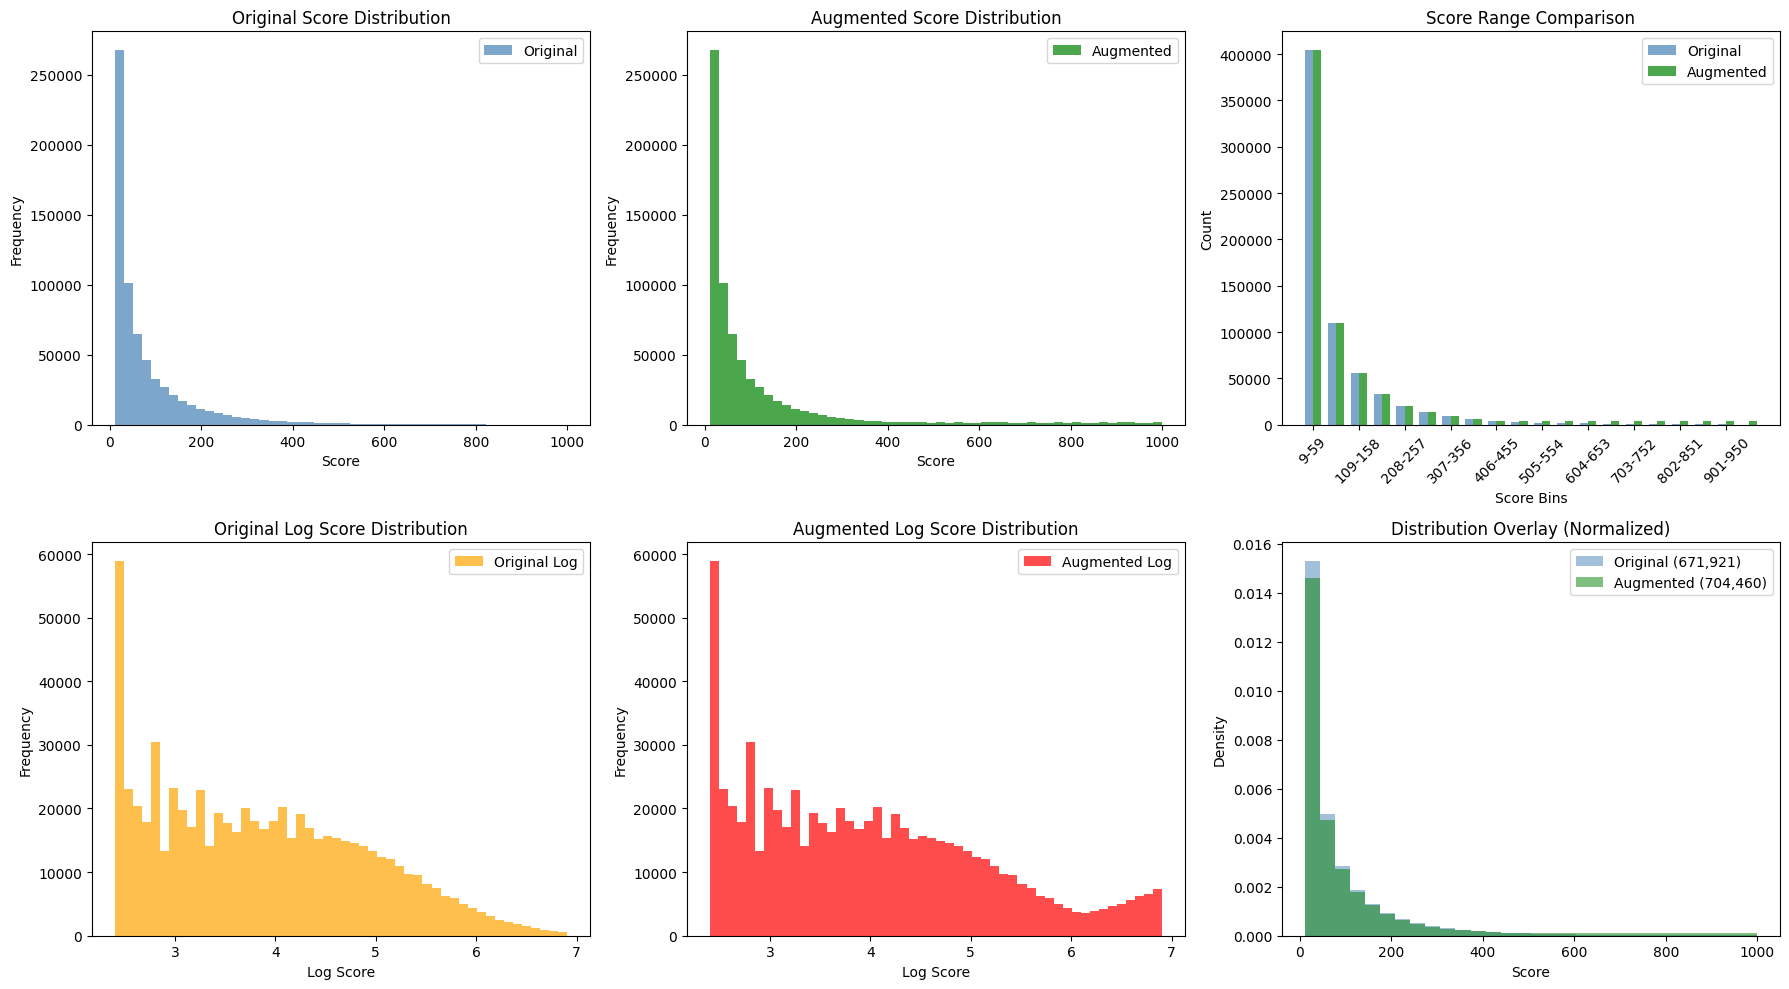


📈 Distribution Statistics Comparison:
Metric          Original     Augmented    Change    
-------------------------------------------------------
count           671921.0     704460.0     +32,539   
mean            85.1         116.8        +37.3%    
std             114.2        184.8        +61.9%    
min             10.0         10.0         +0.0%     
25%             18.0         19.0         +5.6%     
50%             42.0         45.0         +7.1%     
75%             103.0        120.0        +16.5%    
max             1000.0       1000.0       +0.0%     

🎯 Uniformity Check:
Distribution uniformity (lower = more uniform):
  Original CV: 2.373
  Augmented CV: 2.243
  Improvement: +5.5%


In [8]:
# Visualize the augmented distribution
print("📊 Comparing original vs augmented distributions...")

plt.figure(figsize=(18, 10))

# Score distributions
plt.subplot(2, 3, 1)
plt.hist(df_filtered['score'], bins=50, alpha=0.7, color='steelblue', label='Original')
plt.title('Original Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 3, 2)
plt.hist(df_augmented['score'], bins=50, alpha=0.7, color='green', label='Augmented')
plt.title('Augmented Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()

# Score range comparison
plt.subplot(2, 3, 3)
original_ranges = pd.cut(df_filtered['score'], bins=20)
augmented_ranges = pd.cut(df_augmented['score'], bins=20)

original_counts = original_ranges.value_counts().sort_index()
augmented_counts = augmented_ranges.value_counts().sort_index()

x = range(len(original_counts))
width = 0.35

plt.bar([i - width/2 for i in x], original_counts.values, width, 
        label='Original', alpha=0.7, color='steelblue')
plt.bar([i + width/2 for i in x], augmented_counts.values, width, 
        label='Augmented', alpha=0.7, color='green')

plt.title('Score Range Comparison')
plt.xlabel('Score Bins')
plt.ylabel('Count')
plt.legend()
plt.xticks(x[::2], [f'{int(original_counts.index[i].left)}-{int(original_counts.index[i].right)}' 
                    for i in x[::2]], rotation=45)

# Log score distributions
plt.subplot(2, 3, 4)
plt.hist(df_filtered['score_log'], bins=50, alpha=0.7, color='orange', label='Original Log')
plt.title('Original Log Score Distribution')
plt.xlabel('Log Score')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 3, 5)
plt.hist(df_augmented['score_log'], bins=50, alpha=0.7, color='red', label='Augmented Log')
plt.title('Augmented Log Score Distribution')
plt.xlabel('Log Score')
plt.ylabel('Frequency')
plt.legend()

# Overlay comparison
plt.subplot(2, 3, 6)
plt.hist(df_filtered['score'], bins=30, alpha=0.5, color='steelblue', 
         label=f'Original ({len(df_filtered):,})', density=True)
plt.hist(df_augmented['score'], bins=30, alpha=0.5, color='green', 
         label=f'Augmented ({len(df_augmented):,})', density=True)
plt.title('Distribution Overlay (Normalized)')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

# Statistics comparison
print(f"\n📈 Distribution Statistics Comparison:")
print(f"{'Metric':<15} {'Original':<12} {'Augmented':<12} {'Change':<10}")
print("-" * 55)

orig_stats = df_filtered['score'].describe()
aug_stats = df_augmented['score'].describe()

for stat in ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']:
    orig_val = orig_stats[stat]
    aug_val = aug_stats[stat]
    
    if stat == 'count':
        change = f"+{int(aug_val - orig_val):,}"
    else:
        change = f"{((aug_val/orig_val - 1) * 100):+.1f}%"
    
    print(f"{stat:<15} {orig_val:<12.1f} {aug_val:<12.1f} {change:<10}")

print(f"\n🎯 Uniformity Check:")
# Check how uniform the distribution is now
score_ranges_orig = pd.cut(df_filtered['score'], bins=10).value_counts().sort_index()
score_ranges_aug = pd.cut(df_augmented['score'], bins=10).value_counts().sort_index()

orig_cv = score_ranges_orig.std() / score_ranges_orig.mean()  # Coefficient of variation
aug_cv = score_ranges_aug.std() / score_ranges_aug.mean()

print(f"Distribution uniformity (lower = more uniform):")
print(f"  Original CV: {orig_cv:.3f}")
print(f"  Augmented CV: {aug_cv:.3f}")
print(f"  Improvement: {((orig_cv - aug_cv) / orig_cv * 100):+.1f}%")


In [9]:
# Update the rest of the pipeline to use augmented data
print("🔄 Updating feature processing for augmented dataset...")

# Replace df_filtered with df_augmented for the rest of the pipeline
df_filtered = df_augmented.copy()

# Reprocess title embeddings for new/modified titles
print("Reprocessing title features for augmented data...")
title_embeddings = []
word_counts = []

for i, title in enumerate(df_filtered['title']):
    if i % 20000 == 0:
        print(f"  Processing {i:,}/{len(df_filtered):,}...")
    
    emb = title_to_embedding(title)
    word_count = len(title.strip().split())
    
    title_embeddings.append(emb)
    word_counts.append(word_count)

df_filtered['word_count'] = word_counts

print("✅ Feature processing updated for augmented dataset!")
print(f"New dataset size: {len(df_filtered):,} samples")

# Show some examples of augmented titles
print(f"\n📝 Sample augmented titles:")
sample_titles = df_filtered['title'].sample(10, random_state=42)
for i, title in enumerate(sample_titles, 1):
    print(f"  {i:2d}. {title}")

# Verify score distribution coverage
print(f"\n📊 Score coverage verification:")
print(f"Score range: {df_filtered['score'].min():.1f} - {df_filtered['score'].max():.1f}")
print(f"Unique scores: {df_filtered['score'].nunique():,}")

# Show distribution across different score ranges
score_ranges = [(10, 50), (50, 100), (100, 200), (200, 500), (500, 1000)]
for low, high in score_ranges:
    count = len(df_filtered[(df_filtered['score'] >= low) & (df_filtered['score'] < high)])
    pct = count / len(df_filtered) * 100
    print(f"  {low:3d}-{high:3d}: {count:6,} samples ({pct:4.1f}%)")


🔄 Updating feature processing for augmented dataset...
Reprocessing title features for augmented data...
  Processing 0/704,460...
  Processing 20,000/704,460...
  Processing 40,000/704,460...
  Processing 60,000/704,460...
  Processing 80,000/704,460...
  Processing 100,000/704,460...
  Processing 120,000/704,460...
  Processing 140,000/704,460...
  Processing 160,000/704,460...
  Processing 180,000/704,460...
  Processing 200,000/704,460...
  Processing 220,000/704,460...
  Processing 240,000/704,460...
  Processing 260,000/704,460...
  Processing 280,000/704,460...
  Processing 300,000/704,460...
  Processing 320,000/704,460...
  Processing 340,000/704,460...
  Processing 360,000/704,460...
  Processing 380,000/704,460...
  Processing 400,000/704,460...
  Processing 420,000/704,460...
  Processing 440,000/704,460...
  Processing 460,000/704,460...
  Processing 480,000/704,460...
  Processing 500,000/704,460...
  Processing 520,000/704,460...
  Processing 540,000/704,460...
  Process

In [10]:
# Prepare embeddings vocabulary
print("Preparing embedding vocabularies...")

# Domain vocabulary: Keep top domains, group others as 'OTHER'
domain_counts = df_filtered['domain'].value_counts()
top_domains = domain_counts.head(200).index.tolist()  # Keep top 1000 domains
df_filtered['domain_mapped'] = df_filtered['domain'].apply(
    lambda x: x if x in top_domains else 'OTHER'
)

# User vocabulary: Keep top users, group others as 'OTHER'
user_counts = df_filtered['by'].value_counts()
top_users = user_counts.head(1000).index.tolist()  # Keep top 5000 users
df_filtered['user_mapped'] = df_filtered['by'].apply(
    lambda x: x if x in top_users else 'OTHER'
)

# Create label encoders
domain_encoder = LabelEncoder()
user_encoder = LabelEncoder()

domain_ids = domain_encoder.fit_transform(df_filtered['domain_mapped'])
user_ids = user_encoder.fit_transform(df_filtered['user_mapped'])

print(f"Domain vocabulary size: {len(domain_encoder.classes_)}")
print(f"User vocabulary size: {len(user_encoder.classes_)}")

# Store encoders for later use
n_domains = len(domain_encoder.classes_)
n_users = len(user_encoder.classes_)

print("✅ Embedding vocabularies ready!")


Preparing embedding vocabularies...
Domain vocabulary size: 201
User vocabulary size: 1001
✅ Embedding vocabularies ready!


In [11]:
# Prepare final feature matrices
print("Preparing final feature matrices...")

# Features for the neural network:
# 1. Title embeddings (200D)
X_title_embeddings = np.array(title_embeddings)

# 2. Numerical features (scaled): word_count, time_sin, time_cos
numerical_features = np.column_stack([
    df_filtered['word_count'].values,
    df_filtered['time_of_day_sin'].values,
    df_filtered['time_of_day_cos'].values
])

# Scale numerical features
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(numerical_features)

# 3. IDs for embeddings
X_domain_ids = domain_ids
X_user_ids = user_ids

# 4. Target
y = df_filtered['score_log'].values
y_original = df_filtered['score'].values  # Keep for evaluation

print(f"Feature shapes:")
print(f"  Title embeddings: {X_title_embeddings.shape}")
print(f"  Numerical features: {X_numerical_scaled.shape}")
print(f"  Domain IDs: {X_domain_ids.shape}")
print(f"  User IDs: {X_user_ids.shape}")
print(f"  Target: {y.shape}")

# Train/validation/test split
# First split: train+val vs test
indices = np.arange(len(y))
train_val_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

# Second split: train vs val
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

print(f"Split sizes: Train={len(train_idx):,}, Val={len(val_idx):,}, Test={len(test_idx):,}")

print("✅ Feature matrices ready!")


Preparing final feature matrices...
Feature shapes:
  Title embeddings: (704460, 200)
  Numerical features: (704460, 3)
  Domain IDs: (704460,)
  User IDs: (704460,)
  Target: (704460,)
Split sizes: Train=422,676, Val=140,892, Test=140,892
✅ Feature matrices ready!


In [12]:
# Define the combined model architecture
class CombinedScorePredictor(nn.Module):
    def __init__(self, n_domains, n_users, domain_emb_dim=32, user_emb_dim=64, 
                 title_emb_dim=200, numerical_dim=3, hidden_dim=256, dropout=0.3):
        super(CombinedScorePredictor, self).__init__()
        
        # Learnable embeddings
        self.domain_embedding = nn.Embedding(n_domains, domain_emb_dim)
        self.user_embedding = nn.Embedding(n_users, user_emb_dim)
        
        # Calculate total input dimension
        total_input_dim = title_emb_dim + numerical_dim + domain_emb_dim + user_emb_dim
        
        # Main neural network
        self.model = nn.Sequential(
            nn.Linear(total_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, 1)
        )
        
    def forward(self, title_emb, numerical_features, domain_ids, user_ids):
        # Get embeddings
        domain_emb = self.domain_embedding(domain_ids)
        user_emb = self.user_embedding(user_ids)
        
        # Concatenate all features
        combined = torch.cat([
            title_emb,
            numerical_features,
            domain_emb,
            user_emb
        ], dim=1)
        
        # Forward pass
        return self.model(combined).squeeze(1)

# Initialize model
model = CombinedScorePredictor(
    n_domains=n_domains,
    n_users=n_users,
    domain_emb_dim=32,
    user_emb_dim=64,
    title_emb_dim=200,
    numerical_dim=3,
    hidden_dim=256,
    dropout=0.3
).to(device)

print(f"Model architecture:")
print(f"  Domain embedding: {n_domains} -> 32")
print(f"  User embedding: {n_users} -> 64")
print(f"  Total input dim: {200 + 3 + 32 + 64} = {200 + 3 + 32 + 64}")
print(f"  Hidden layers: 299 -> 256 -> 128 -> 64 -> 1")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

print("✅ Combined model ready!")


Model architecture:
  Domain embedding: 201 -> 32
  User embedding: 1001 -> 64
  Total input dim: 299 = 299
  Hidden layers: 299 -> 256 -> 128 -> 64 -> 1
  Total parameters: 188,513
✅ Combined model ready!


In [15]:
# Training setup
def create_data_loader(indices, batch_size=512, shuffle=True):
    """Create data loader for given indices"""
    title_emb_batch = torch.FloatTensor(X_title_embeddings[indices]).to(device)
    numerical_batch = torch.FloatTensor(X_numerical_scaled[indices]).to(device)
    domain_batch = torch.LongTensor(X_domain_ids[indices]).to(device)
    user_batch = torch.LongTensor(X_user_ids[indices]).to(device)
    target_batch = torch.FloatTensor(y[indices]).to(device)
    
    dataset = TensorDataset(title_emb_batch, numerical_batch, domain_batch, user_batch, target_batch)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Create data loaders
train_loader = create_data_loader(train_idx, batch_size=512, shuffle=True)
val_loader = create_data_loader(val_idx, batch_size=512, shuffle=False)
test_loader = create_data_loader(test_idx, batch_size=512, shuffle=False)

# Training configuration
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

print(f"Training setup:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Optimizer: AdamW (lr=0.01, weight_decay=1e-4)")

print("✅ Training setup complete!")


Training setup:
  Train batches: 826
  Val batches: 276
  Test batches: 276
  Optimizer: AdamW (lr=0.01, weight_decay=1e-4)
✅ Training setup complete!


In [ ]:
# Test predictions on REAL data from test set
print("🧪 Testing predictions on REAL examples from test set:")
print("=" * 70)

# Sample some interesting examples from test set
np.random.seed(42)  # For reproducible results
n_test_examples = 10

# Get test data
test_indices = test_idx
test_sample_indices = np.random.choice(test_indices, n_test_examples, replace=False)

# Create comparison
predictions_vs_actual = []

for i, idx in enumerate(test_sample_indices):
    # Get actual data
    row = df_filtered.iloc[idx]
    actual_score = int(row['score'])
    title = row['title']
    domain = row['domain']
    user = row['by']
    hour = row['hour_of_day']
    
    # Get prediction
    predicted_score = predict_story_score(title, domain, user, hour)
    
    # Store for analysis
    predictions_vs_actual.append({
        'title': title,
        'actual': actual_score,
        'predicted': predicted_score,
        'domain': domain,
        'user': user,
        'hour': hour
    })
    
    # Calculate error
    error = abs(predicted_score - actual_score)
    error_pct = (error / actual_score) * 100 if actual_score > 0 else 0
    
    print(f"\n{i+1:2d}. Title: '{title[:60]}{'...' if len(title) > 60 else ''}'")
    print(f"    Domain: {domain}, User: {user}, Hour: {hour:.1f}")
    print(f"    Actual: {actual_score:4d} | Predicted: {predicted_score:4d} | Error: ±{error:4d} ({error_pct:.1f}%)")

# Calculate summary statistics
df_comparison = pd.DataFrame(predictions_vs_actual)

print(f"\n📊 PREDICTION ACCURACY SUMMARY:")
print("=" * 50)

# Basic error metrics
mae = np.mean(np.abs(df_comparison['predicted'] - df_comparison['actual']))
rmse = np.sqrt(np.mean((df_comparison['predicted'] - df_comparison['actual'])**2))
mape = np.mean(np.abs((df_comparison['predicted'] - df_comparison['actual']) / df_comparison['actual'])) * 100

print(f"Mean Absolute Error (MAE):     {mae:.1f} points")
print(f"Root Mean Square Error (RMSE): {rmse:.1f} points")
print(f"Mean Absolute Percentage Error: {mape:.1f}%")

# Correlation between predicted and actual
correlation = np.corrcoef(df_comparison['predicted'], df_comparison['actual'])[0,1]
print(f"Prediction Correlation:        {correlation:.3f}")

# Check how often we get the "direction" right (high vs low scores)
median_actual = df_comparison['actual'].median()
actual_high = df_comparison['actual'] > median_actual
predicted_high = df_comparison['predicted'] > median_actual
direction_accuracy = (actual_high == predicted_high).mean() * 100

print(f"Direction Accuracy (high/low): {direction_accuracy:.1f}%")

# Score range analysis
print(f"\n🎯 SCORE RANGE BREAKDOWN:")
print("=" * 30)

score_ranges = [(10, 50), (50, 100), (100, 200), (200, 500), (500, 1000)]
for low, high in score_ranges:
    range_mask = (df_comparison['actual'] >= low) & (df_comparison['actual'] < high)
    if range_mask.any():
        range_data = df_comparison[range_mask]
        range_mae = np.mean(np.abs(range_data['predicted'] - range_data['actual']))
        print(f"  {low:3d}-{high:3d} points: {len(range_data)} samples, MAE = {range_mae:.1f}")

print(f"\n💡 INSIGHTS:")
print("=" * 15)
if mape < 50:
    print("✅ Model predictions are reasonably accurate!")
elif mape < 100:
    print("🟡 Model shows some predictive ability, but with high variance")
else:
    print("❌ Model predictions are quite uncertain")

if correlation > 0.3:
    print("✅ Strong correlation between predicted and actual scores!")
elif correlation > 0.1:
    print("🟡 Moderate correlation - model captures some patterns")
else:
    print("❌ Weak correlation - model may be overfitting or missing key signals")

if direction_accuracy > 70:
    print("✅ Good at identifying high vs low scoring content!")
elif direction_accuracy > 60:
    print("🟡 Decent at ranking relative content quality")
else:
    print("❌ Struggles to rank content effectively")

# Optional: Plot predictions vs actual
try:
    plt.figure(figsize=(10, 6))
    
    plt.subplot(1, 2, 1)
    plt.scatter(df_comparison['actual'], df_comparison['predicted'], alpha=0.7)
    plt.plot([df_comparison['actual'].min(), df_comparison['actual'].max()], 
             [df_comparison['actual'].min(), df_comparison['actual'].max()], 
             'r--', label='Perfect prediction')
    plt.xlabel('Actual Score')
    plt.ylabel('Predicted Score')
    plt.title(f'Predicted vs Actual\n(R = {correlation:.3f})')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    errors = df_comparison['predicted'] - df_comparison['actual']
    plt.hist(errors, bins=8, alpha=0.7, edgecolor='black')
    plt.xlabel('Prediction Error (Predicted - Actual)')
    plt.ylabel('Count')
    plt.title(f'Error Distribution\n(MAE = {mae:.1f})')
    plt.axvline(0, color='red', linestyle='--', label='Perfect prediction')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Note: Could not create plots - {e}")


In [16]:
# Training loop
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    num_batches = 0
    
    for title_emb, numerical, domain_ids, user_ids, targets in train_loader:
        optimizer.zero_grad()
        
        outputs = model(title_emb, numerical, domain_ids, user_ids)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for title_emb, numerical, domain_ids, user_ids, targets in data_loader:
            outputs = model(title_emb, numerical, domain_ids, user_ids)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    
    # Calculate R² on original scale
    predictions_orig = np.expm1(all_predictions)
    targets_orig = np.expm1(all_targets)
    r2 = r2_score(targets_orig, predictions_orig)
    rmse = np.sqrt(mean_squared_error(targets_orig, predictions_orig))
    r2_log = r2_score(np.log1p(targets_orig), np.log1p(predictions_orig))
    
    return avg_loss, r2, rmse, r2_log

print("✅ Training functions ready!")


✅ Training functions ready!


In [ ]:
# Main training loop
print("🚀 Starting training...")

num_epochs = 100
best_val_r2 = -float('inf')
patience_counter = 0
max_patience = 100

# Training history
train_losses = []
val_losses = []
val_r2_scores = []
val_rmse_scores = []
val_r2_log_scores = []

for epoch in range(num_epochs):
    # Training
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    
    # Validation
    val_loss, val_r2, val_rmse, val_r2_log = evaluate_model(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_r2_scores.append(val_r2)
    val_rmse_scores.append(val_rmse)
    val_r2_log_scores.append(val_r2_log)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Early stopping
    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_combined_model.pth')
    else:
        patience_counter += 1
    
    print(f"Epoch {epoch+1:2d}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, "
          f"Val Loss={val_loss:.4f}, "
          f"Val R²={val_r2:.4f}, "
          f"Val RMSE={val_rmse:.1f}",
          f"Val R² (log scale): {val_r2_log:.4f}")
    
    if patience_counter >= max_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

print(f"\n✅ Training complete!")
print(f"Best validation R²: {best_val_r2:.4f}")


🚀 Starting training...
Epoch  1/100: Train Loss=2.1392, Val Loss=2.0074, Val R²=-0.2460, Val RMSE=207.0 Val R² (log scale): -0.4398
Epoch  2/100: Train Loss=1.3322, Val Loss=1.7106, Val R²=-0.2084, Val RMSE=203.9 Val R² (log scale): -0.2270
Epoch  3/100: Train Loss=1.2966, Val Loss=1.6699, Val R²=-0.2032, Val RMSE=203.5 Val R² (log scale): -0.1978
Epoch  4/100: Train Loss=1.2779, Val Loss=1.3310, Val R²=-0.1217, Val RMSE=196.4 Val R² (log scale): 0.0455
Epoch  5/100: Train Loss=1.2632, Val Loss=1.3315, Val R²=-0.1227, Val RMSE=196.5 Val R² (log scale): 0.0451
Epoch  6/100: Train Loss=1.2550, Val Loss=1.3129, Val R²=-0.1109, Val RMSE=195.5 Val R² (log scale): 0.0585
Epoch  7/100: Train Loss=1.2461, Val Loss=1.2794, Val R²=-0.0818, Val RMSE=192.9 Val R² (log scale): 0.0826
Epoch  8/100: Train Loss=1.2400, Val Loss=1.2757, Val R²=-0.0852, Val RMSE=193.2 Val R² (log scale): 0.0852
Epoch  9/100: Train Loss=1.2315, Val Loss=1.2567, Val R²=-0.0602, Val RMSE=191.0 Val R² (log scale): 0.0988
Ep

📊 Final evaluation on test set...

🎯 FINAL RESULTS:
  Test Loss (log scale): 1.0384
  Test R²: -0.0504
  Test RMSE: 115.9 points
  Test R² (log scale): 0.0572


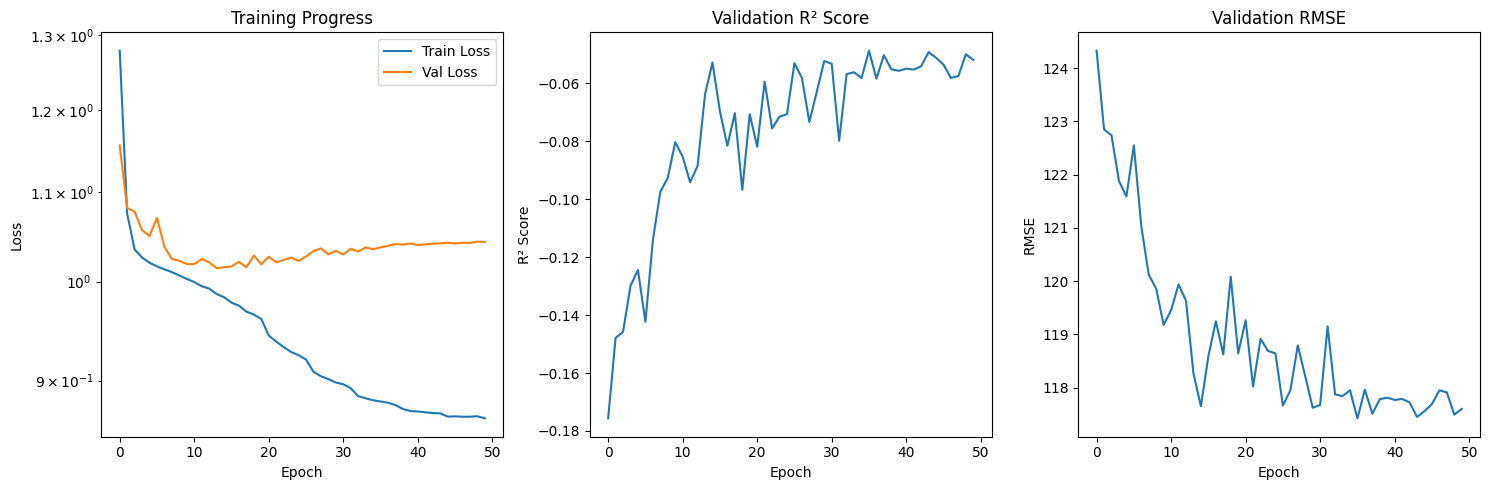

✅ Evaluation complete!


In [32]:
# Load best model and evaluate on test set
print("📊 Final evaluation on test set...")

# Load best model
model.load_state_dict(torch.load('best_combined_model.pth'))

# Test evaluation
test_loss, test_r2, test_rmse, test_r2_log = evaluate_model(model, test_loader, criterion)

print(f"\n🎯 FINAL RESULTS:")
print(f"  Test Loss (log scale): {test_loss:.4f}")
print(f"  Test R²: {test_r2:.4f}")
print(f"  Test RMSE: {test_rmse:.1f} points")
print(f"  Test R² (log scale): {test_r2_log:.4f}")

# Training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.yscale('log')

plt.subplot(1, 3, 2)
plt.plot(val_r2_scores)
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.title('Validation R² Score')

plt.subplot(1, 3, 3)
plt.plot(val_rmse_scores)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Validation RMSE')

plt.tight_layout()
plt.show()

print("✅ Evaluation complete!")


In [33]:
# Prediction function for new stories
def predict_story_score(title, domain, user, hour_of_day=12):
    """Predict score for a new story"""
    model.eval()
    
    # Process title
    title_emb = title_to_embedding(title)
    word_count = len(title.strip().split())
    
    # Time features
    time_sin = np.sin(2 * np.pi * hour_of_day / 24)
    time_cos = np.cos(2 * np.pi * hour_of_day / 24)
    
    # Map domain and user
    domain_mapped = domain if domain in domain_encoder.classes_ else 'OTHER'
    user_mapped = user if user in user_encoder.classes_ else 'OTHER'
    
    try:
        domain_id = domain_encoder.transform([domain_mapped])[0]
        user_id = user_encoder.transform([user_mapped])[0]
    except:
        # Fallback to 'OTHER'
        domain_id = domain_encoder.transform(['OTHER'])[0]
        user_id = user_encoder.transform(['OTHER'])[0]
    
    # Create tensors
    title_tensor = torch.FloatTensor(title_emb).unsqueeze(0).to(device)
    numerical_tensor = torch.FloatTensor(scaler.transform([[word_count, time_sin, time_cos]])).to(device)
    domain_tensor = torch.LongTensor([domain_id]).to(device)
    user_tensor = torch.LongTensor([user_id]).to(device)
    
    # Predict
    with torch.no_grad():
        pred_log = model(title_tensor, numerical_tensor, domain_tensor, user_tensor)
        pred_orig = np.expm1(pred_log.cpu().item())
    
    return max(1, int(pred_orig))  # Ensure positive integer

# Test predictions
print("🧪 Testing predictions:")

test_examples = [
    ("Show HN: I built an amazing AI tool for developers", "github.com", "someuser", 10),
    ("Apple announces new iPhone with revolutionary features", "apple.com", "techuser", 14),
    ("Ask HN: How to learn machine learning in 2024?", "self_post", "student123", 20),
    ("YC Startup raises $50M Series A funding round", "techcrunch.com", "reporter", 9),
    ("Simple Python script that changed my workflow", "github.com", "programmer", 16)
]

for title, domain, user, hour in test_examples:
    score = predict_story_score(title, domain, user, hour)
    print(f"  '{title[:50]}...' -> {score} points")

print(f"\n📈 Model Summary:")
print(f"  Architecture: Combined embeddings + features")
print(f"  Input features:")
print(f"    - Title embeddings: 200D (GloVe)")
print(f"    - Word count: 1D (scaled)")
print(f"    - Time features: 2D (sin/cos)")
print(f"    - Domain embeddings: 32D (learnable)")
print(f"    - User embeddings: 64D (learnable)")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Final test R²: {test_r2:.4f}")

if test_r2 > 0.1:
    print("  ✅ Model shows good predictive power!")
elif test_r2 > 0.05:
    print("  🟡 Model shows moderate predictive power")
else:
    print("  ❌ Model needs further improvement")

print("\n✅ Combined model is ready for use!")


🧪 Testing predictions:
  'Show HN: I built an amazing AI tool for developers...' -> 53 points
  'Apple announces new iPhone with revolutionary feat...' -> 80 points
  'Ask HN: How to learn machine learning in 2024?...' -> 23 points
  'YC Startup raises $50M Series A funding round...' -> 37 points
  'Simple Python script that changed my workflow...' -> 75 points

📈 Model Summary:
  Architecture: Combined embeddings + features
  Input features:
    - Title embeddings: 200D (GloVe)
    - Word count: 1D (scaled)
    - Time features: 2D (sin/cos)
    - Domain embeddings: 32D (learnable)
    - User embeddings: 64D (learnable)
  Total parameters: 188,513
  Final test R²: -0.0504
  ❌ Model needs further improvement

✅ Combined model is ready for use!


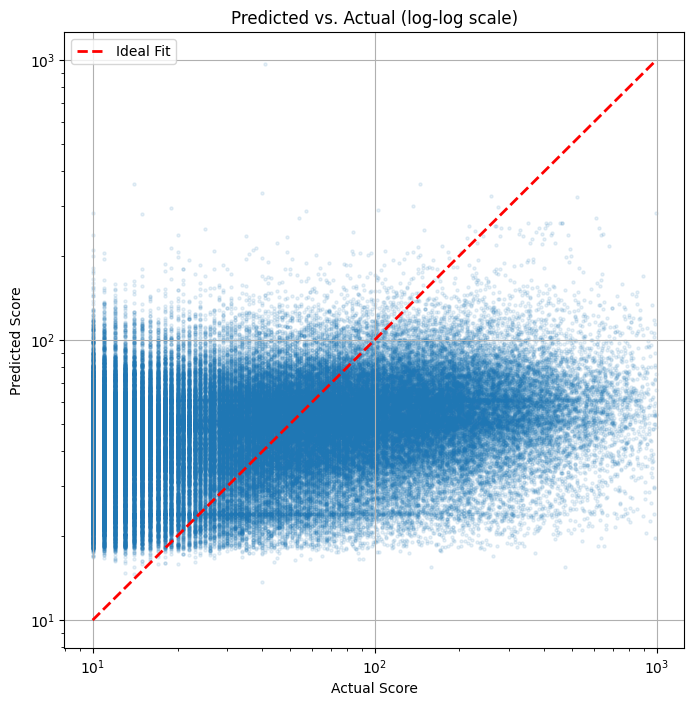

In [34]:
# ── PREDICTED vs ACTUAL SCATTER ─────────────────────
with torch.no_grad():
    preds_log = []
    true_log  = []
    for title_emb, numerical, d_ids, u_ids, targets in test_loader:
        outputs = model(title_emb, numerical, d_ids, u_ids)
        preds_log.extend(outputs.cpu().numpy())
        true_log.extend(targets.cpu().numpy())

y_pred_orig = np.expm1(preds_log)
y_true_orig = np.expm1(true_log)

plt.figure(figsize=(8, 8))
plt.scatter(y_true_orig, y_pred_orig, alpha=0.1, s=5)
plt.plot([y_true_orig.min(), y_true_orig.max()],
         [y_true_orig.min(), y_true_orig.max()],
         'r--', lw=2, label='Ideal Fit')
plt.xscale('log');  plt.yscale('log')
plt.xlabel('Actual Score');     plt.ylabel('Predicted Score')
plt.title('Predicted vs. Actual (log-log scale)')
plt.grid(True);      plt.legend();      plt.show()